In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
voxel_size = np.array([0.0005, 0.0005, 0.0005])
surface_mesh = o3d.io.read_triangle_mesh(f"{parent}/assets/kidney_phantom/00_abdomen_cropped.obj")
body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh)

In [3]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (voxel_size[0], voxel_size[0], voxel_size[0]),
                               matrix_dims = body_mask.shape,
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

kidney = tissue.Tissue(name='renal_cortex', c=1571.3, rho=1049, sigma=0, scale=0.0001, label=3)
blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=0, scale=0.00001, label=1)
medulla = tissue.Tissue(name='renal_medulla', c=1564, rho=1044, sigma=0, scale=0.0001, label=2)
cortex = tissue.Tissue(name='renal_cortex', c=1571.3, rho=1049, sigma=0, scale=0.0001, label=3)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=30, scale=0.0001, label=4)
connective = tissue.Tissue(name='connective_tissue', c=1450, rho=1027, sigma=0, scale=0.0005, label=5)
muscle = tissue.Tissue(name='muscle', c=1580, rho=1090, sigma=4, scale=0.001, label=6)
bone = tissue.Tissue(name='bone', c=2500, rho=1800, sigma=0, scale=0.0001, label=7) # Running simulations with high sos tissue requires a larger grid_lambda parameter to maintain stability

kidney_file_dir = f"{parent}/assets/kidney_phantom"
kidney_tissue_list = [fat, muscle, muscle, bone, cortex, cortex, medulla, medulla, blood]

test_phantom.build_organ_from_mesh(surface_mesh, voxel_size[0], kidney_tissue_list, dir_path = kidney_file_dir)
test_phantom.set_default_tissue('water')

Added fat
Added muscle
Added muscle
Added bone
Added renal_cortex
Added renal_cortex
Added renal_medulla
Added renal_medulla
Added blood


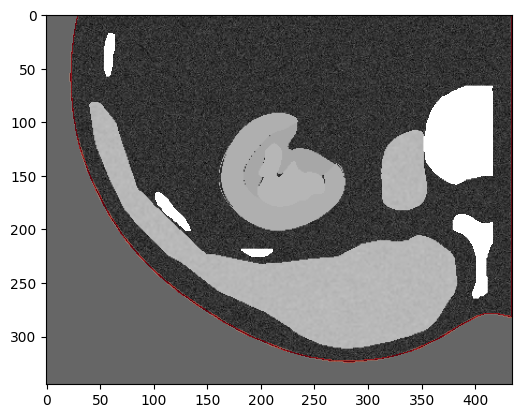

In [4]:
index = 235
plt.imshow(test_phantom.get_complete()[0, :, :, index], cmap='gray', vmin=1400, vmax=1650)
plt.imshow(body_mask[:,:, index], alpha=(body_mask[:,:, index]>0)*0.9, cmap='Reds')

In [5]:
num_transducers = 1
# transducers = [transducer.Planewave(max_frequency=1e6,
#                                     elements = 32, 
#                                     width = 20e-3,
#                                     height =  20e-3,
#                                     sensor_sampling_scheme = 'not_centroid', 
#                                     sweep = np.pi/3,
#                                     ray_num = 3, 
#                                     imaging_ndims = 2,
#                                     focus_elevation = 20e-3,
#                                     ) for i in range(num_transducers)]

transducers = [transducer.Focused(max_frequency = 2e6,
                                  elements = 128, 
                                  width = 40e-3,
                                  height =  20e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = np.pi/2,
                                  ray_num = 16,
                                  imaging_ndims = 2,
                                  focus_azimuth = 190-3,
                                  focus_elevation = 120-3) for i in range(num_transducers)]


for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [6]:
pt, normal = test_transducer_set.place_on_mesh_voxel(0, surface_mesh,[220,70,340], voxel_size[0])
transducer_pose = geometry.Transform(rotation=(np.pi * 0.65, np.pi * 0.15, np.pi * 0.6), translation=pt)
test_transducer_set.assign_pose(0, transducer_pose)

In [7]:
# pt, normal = test_transducer_set.place_on_mesh_voxel(0, surface_mesh,[220,70,310], voxel_size[0])
# normal = -normal
# normal = np.array([normal[0] + 0.3, normal[1] - 0.3, normal[2] - 0.3])
# normal = normal / np.linalg.norm(normal)
# pose = geometry.Transform.make_from_heading_vector(normal, pt)
# theta = np.pi * .45
# about_nl_axis = geometry.Transform(rotation=tuple(theta * normal), translation=(0,0,0), about_axis=True)
# transducer_pose = about_nl_axis * pose
# test_transducer_set.assign_pose(0, transducer_pose)

In [8]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='extended_aperture')

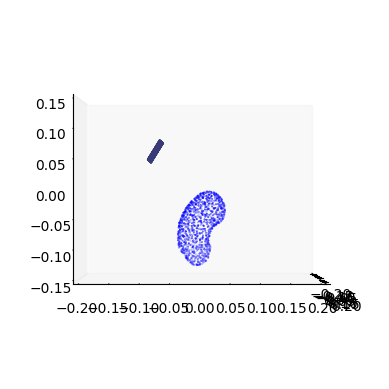

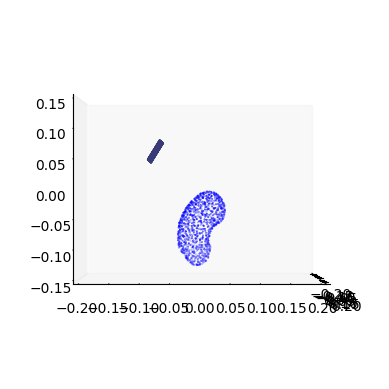

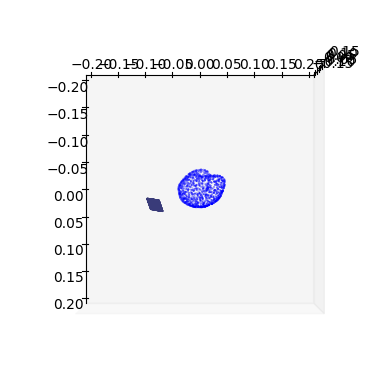

In [9]:
points = np.array((o3d.io.read_triangle_mesh(f"{parent}/assets/kidney_phantom/04_VH_M_kidney_capsule_L.obj")).sample_points_uniformly(1000).points)
points = points[:,[0,1,2]] - np.mean(points, axis=0)

test_transducer_set.plot_transducer_coords(scale = 0.2, phantom_coords = points, view=(0,0))
test_transducer_set.plot_transducer_coords(scale = 0.2, phantom_coords = points, view=(0,0))
test_transducer_set.plot_transducer_coords(scale = 0.2, phantom_coords = points, view=(90,0))

In [10]:
simprops = simulation.SimProperties(
                grid_size   = (180e-3,90e-3,40e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                grid_lambda = 2,               # 
                )

In [11]:
test_experiment = experiment.Experiment(
                 simulation_path = 'kidney_experiment_sa',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 2,
                 additional_keys = []
                 )

test_experiment.save()

In [12]:
sensor_coord = np.mean(test_sensor.sensor_coords, axis=0) / voxel_size + np.array(test_phantom.matrix_dims)/2
sensor_coord

array([226.22904241,  62.82119334, 339.50161505])

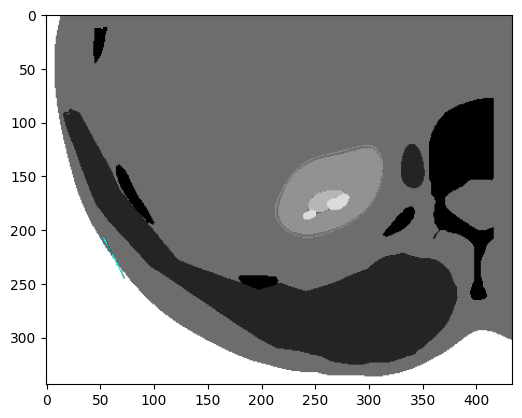

In [13]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), int(np.round(sensor_coord[2]))], body_surface_mask=body_mask)

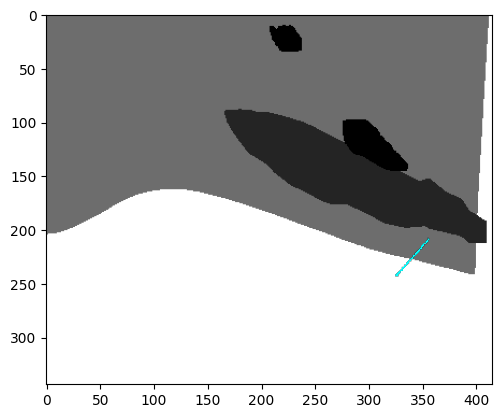

In [14]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1),int(np.round(sensor_coord[1])), slice(0, -1, 1), ], body_surface_mask=body_mask)

In [15]:
# test_experiment.plot_ray_path(0)

In [2]:
test_experiment = experiment.Experiment.load('kidney_experiment_sa')
test_experiment.run(dry=True)

dry run of simulation


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


In [3]:
test_experiment.run(repeat=False)

Found no more simulations to run.


In [4]:
test_experiment.add_results()

In [5]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)

In [6]:
signals = test_reconstruction.get_signals(dimensions=2, matsize=256, downsample=1, workers=16, tgc=5)

100%|██████████| 16/16 [00:43<00:00,  2.70s/it]
1it [00:06,  6.06s/it]


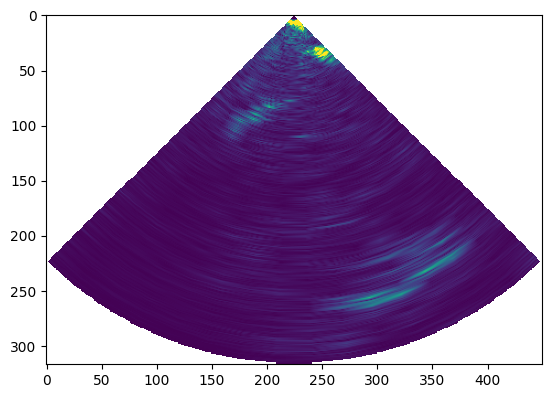

In [7]:
plt.imshow(signals[0], vmax=80000)


In [8]:
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

In [9]:
images2 = test_reconstruction.compound(workers=16, resolution_multiplier=2, local=True, combine=False, return_local=True, attenuation_factor=8)

100%|██████████| 16/16 [00:00<00:00, 340654.13it/s]


In [10]:
image2 = np.sum(images2, axis=0)/len(images2)

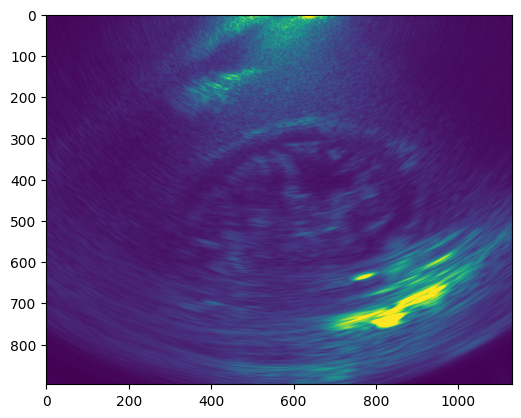

In [11]:
plt.imshow(image2[:,:,0], vmin=0, vmax=200)

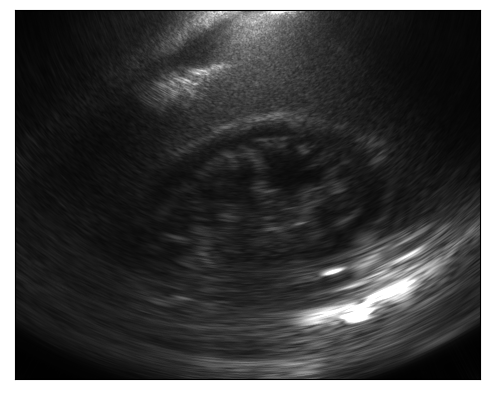

In [17]:
plt.imshow(image2[:,:,0], vmin=0, vmax=180, cmap='gray')
plt.gca().set_facecolor('black')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.savefig('kidney_syntheticaperture_2MHz.png', bbox_inches='tight', pad_inches=0, dpi=300)

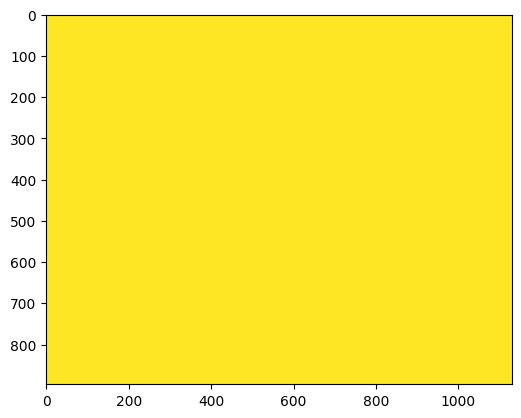

In [27]:
plt.imshow(image2[:,:,0], vmin=0, vmax=50)